In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [3]:
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
import cv2
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *

In [5]:
df_keyfacial = pd.read_csv('C:/Users/arjun/Emotion/data.csv')

In [6]:
df_keyfacial.head(3)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   
2                 36.320968  ...   53.538947            60.822947   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   
2               47.274947               70.191789                  47.274947   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   
2                  78.659368   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  
2  144 142 159 180 188 188 184 180 167 132 84 59 ...  

[3 rows x 31 columns]

In [7]:
df_keyfacial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [8]:
df_keyfacial['Image'].shape

(2140,)

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
df_keyfacial['Image'] = df_keyfacial['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep =' ').reshape(96,96))

In [10]:
# Obtain the Shape of the image
df_keyfacial['Image'][0].shape

(96, 96)

In [11]:
#Obtain the average, minimum and maximum values for 'right_eye_center_x'
df_keyfacial.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

## IMAGE VISUALIZATION 

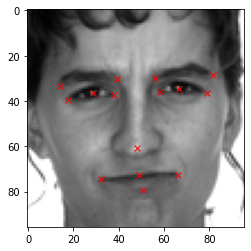

In [12]:
# Plot a random image from the dataset along with facial keypoints. 
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

i = np.random.randint(1, len(df_keyfacial))
plt.imshow(df_keyfacial['Image'][i], cmap = 'gray')
for j in range(1,31,2):
    plt.plot(df_keyfacial.iloc[i][j-1], df_keyfacial.iloc[i][j], 'rx')

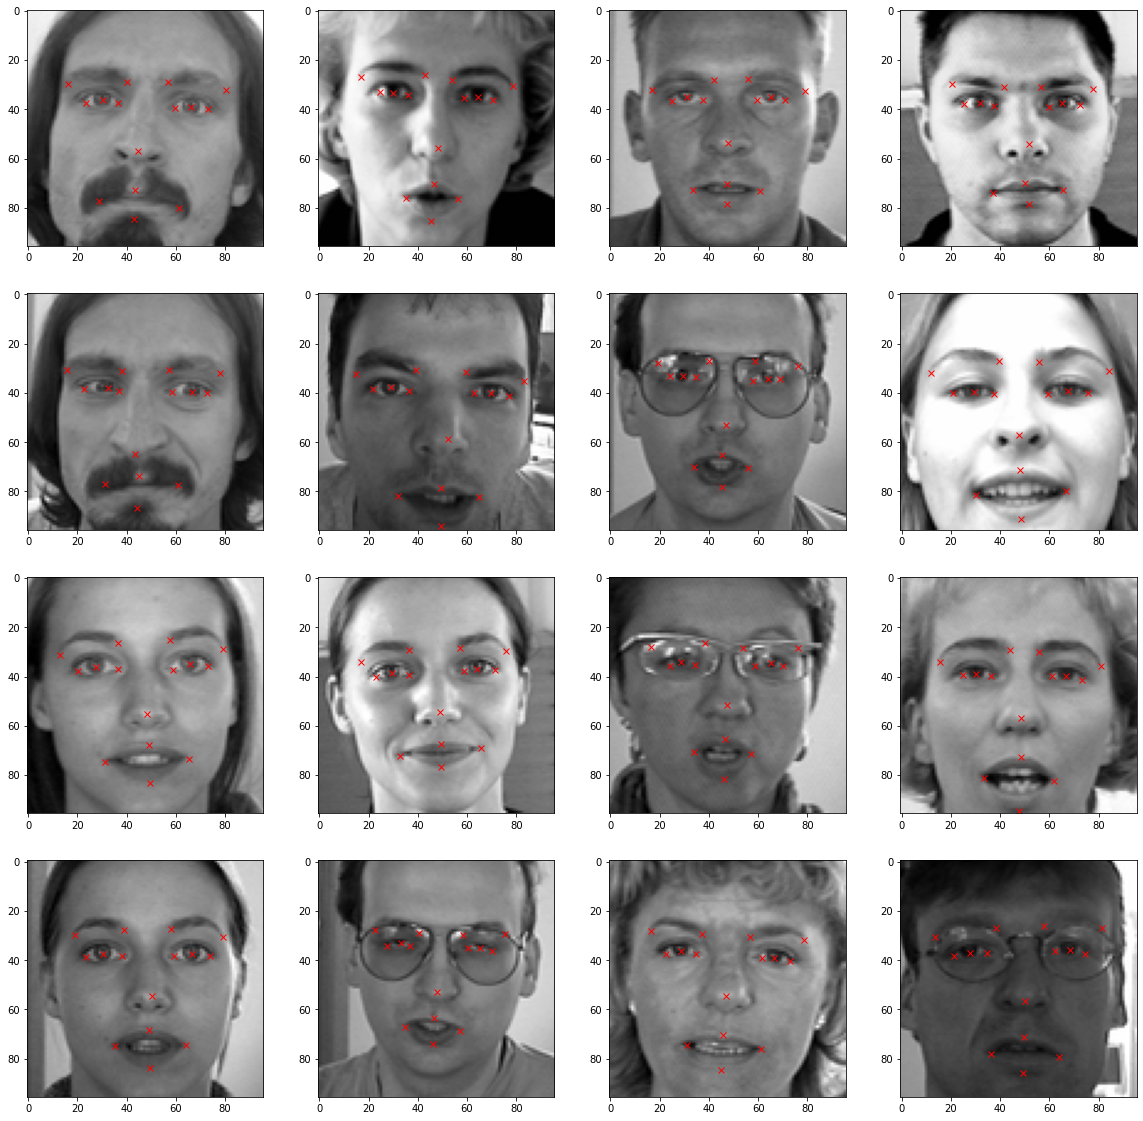

In [13]:
# Let's view more images in a grid format
fig = plt.figure(figsize = (20, 20))

for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    image = plt.imshow(df_keyfacial['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(df_keyfacial.iloc[i][j-1], df_keyfacial.iloc[i][j], 'rx')

Perform a sanity check on the data by randomly visualizing 64 new images along with their cooresponding key points


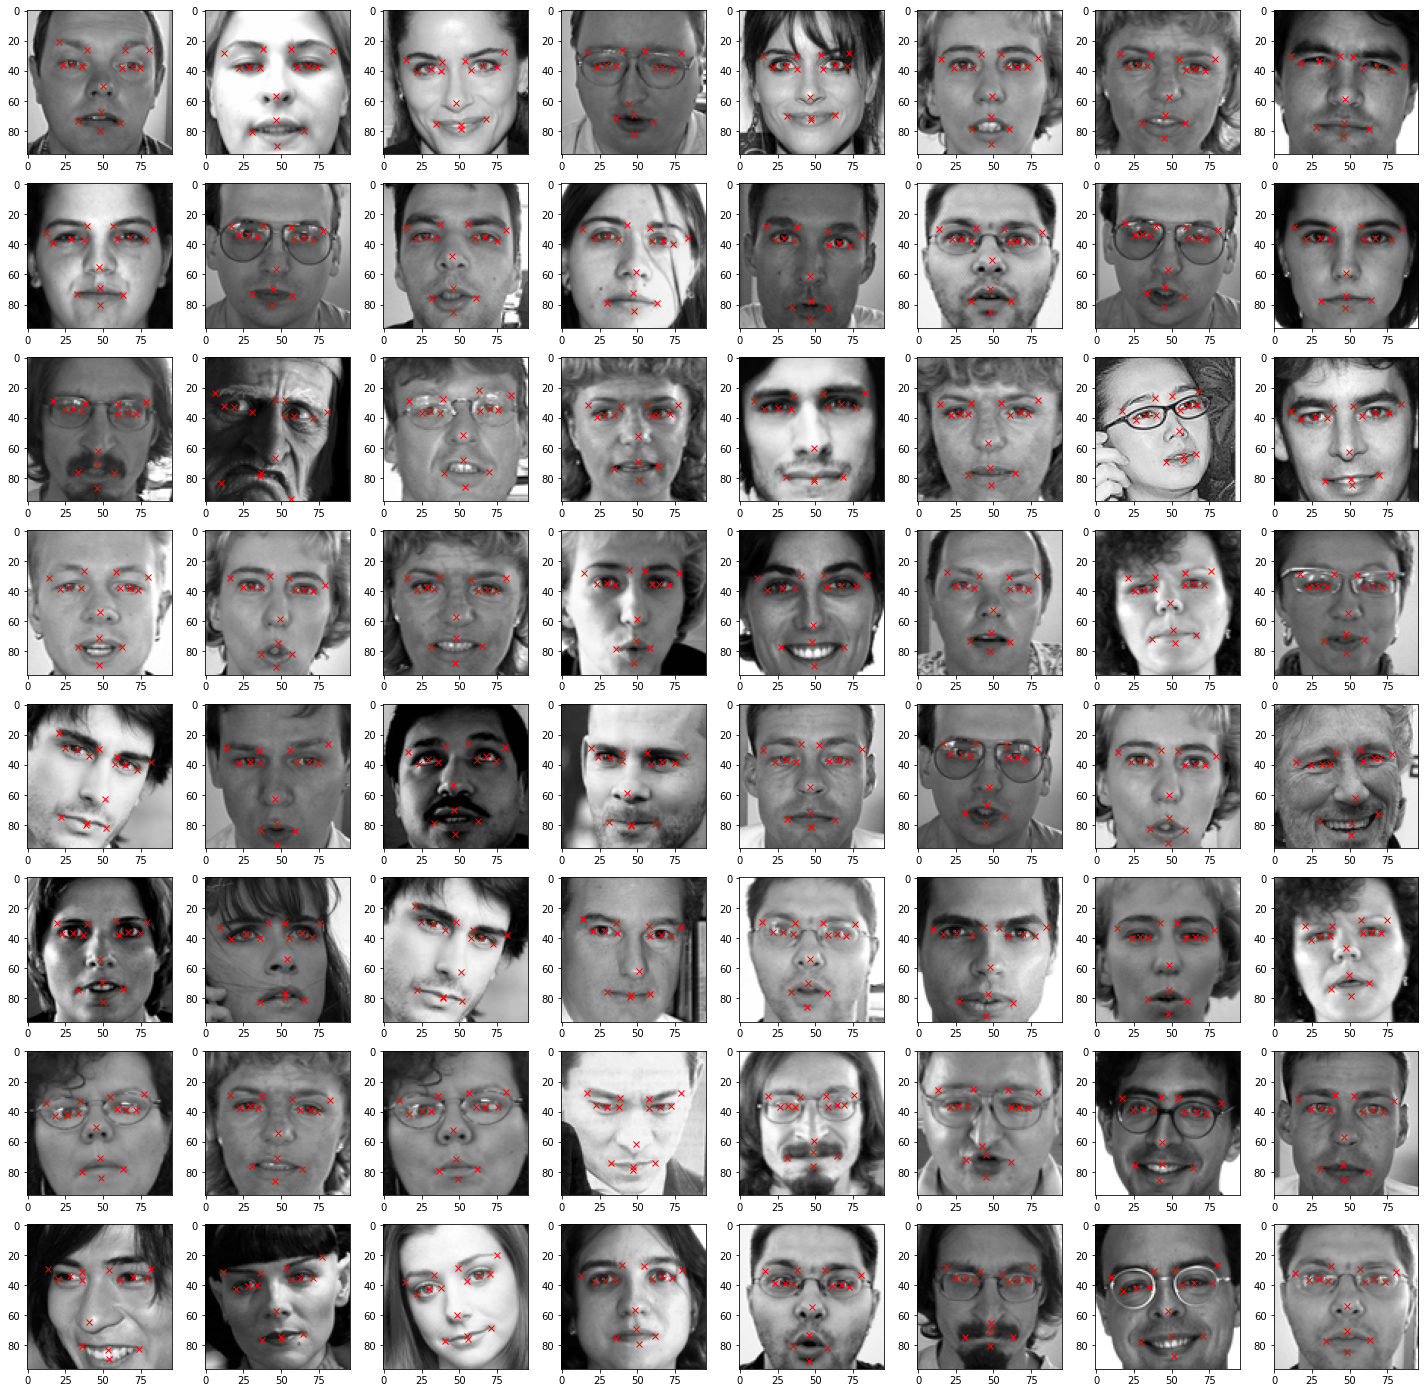

In [14]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(25, 25))
import random
for i in range(64):
    k = random.randint(1, len(df_keyfacial))
    ax = fig.add_subplot(8,8,i+1)
    image = plt.imshow(df_keyfacial['Image'][k], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(df_keyfacial.iloc[k][j-1], df_keyfacial.iloc[k][j], 'rx')

## IMAGE AUGMENTATION 

In [15]:
#Here we flip the images vertically, horizontally, zoom in, play around with the brightness to increase the generalization capability of the model

In [16]:
import copy
df_keyfacial_copy = copy.copy(df_keyfacial)

In [17]:
# Obtain the columns in the dataframe

columns = df_keyfacial_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [18]:
# Horizontal Flip - flip the images along y axis
df_keyfacial_copy['Image'] = df_keyfacial_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
                                                              

In [19]:
# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
    if i%2 == 0:
        df_keyfacial_copy[columns[i]] = df_keyfacial_copy[columns[i]].apply(lambda x: 96. - float(x))

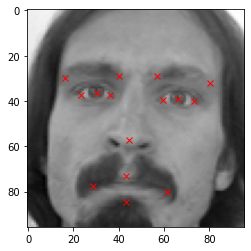

In [20]:
#Show the original image
plt.imshow(df_keyfacial['Image'][0], cmap = 'gray')
for j in range(1,31,2):
    plt.plot(df_keyfacial.iloc[0][j-1], df_keyfacial.iloc[0][j], 'rx')

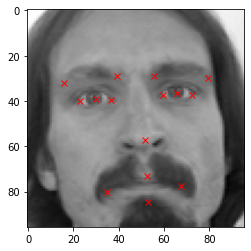

In [21]:
# Show the Horizontally flipped image
plt.imshow(df_keyfacial_copy['Image'][0], cmap = 'gray')
for j in range(1,31,2):
    plt.plot(df_keyfacial_copy.iloc[0][j-1], df_keyfacial_copy.iloc[0][j], 'rx')

In [22]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((df_keyfacial, df_keyfacial_copy))

In [23]:
augmented_df.shape

(4280, 31)

In [24]:
# Randomingly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255
df_keyfacial_copy = copy.copy(df_keyfacial)
df_keyfacial_copy['Image'] = df_keyfacial_copy['Image'].apply(lambda x: np.clip(random.uniform(1.5,2)*x, 0.0, 255))

In [25]:
augmented_df = np.concatenate((augmented_df, df_keyfacial_copy))

In [26]:
augmented_df.shape

(6420, 31)

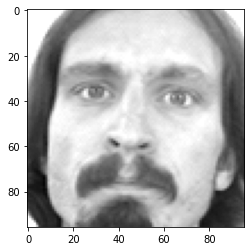

In [27]:
#Show image with increased brightness
plt.imshow(df_keyfacial_copy['Image'][0], cmap = 'gray')

In [28]:
#Augment images by flipping them vertically 
#(Hint: Flip along x-axis and note that if we are flipping along x-axis, x co-ordinates won't change)

In [29]:
df_keyfacial_copy = copy.copy(df_keyfacial)
df_keyfacial_copy['Image'] = df_keyfacial_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
for i in range(len(df_keyfacial.columns)):
    if i%2!=0:
        df_keyfacial_copy[columns[i]] = df_keyfacial_copy[columns[i]].apply(lambda x: 96. - float(x))
    
    

Perform a sanity check and visualize sample images

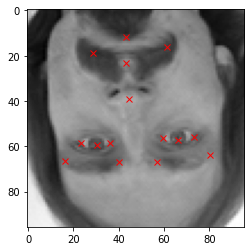

In [30]:
plt.imshow(df_keyfacial_copy['Image'][0], cmap = 'gray')

for i in range (1, 31, 2):
    plt.plot(df_keyfacial_copy.iloc[0][i-1], df_keyfacial_copy.iloc[0][i], 'rx')

## PERFORM DATA NORMALIZATION AND TRAINING DATA PREPARATION 

In [31]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]
#Normalise the images
img = img/255.
#Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty ((len(img), 96, 96, 1))
for i in range(len(img)):
    X[i,] = np.expand_dims(img[i], axis = 2)
# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [32]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [33]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [34]:
X_train.shape

(5136, 96, 96, 1)

In [35]:
X_test.shape

(1284, 96, 96, 1)

##  BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL


In [36]:
def res_block(X, filter, stage):
    #Convolutional_block
    X_copy = X
    f1, f2, f3 = filter
    
    #Main Path
    X = Conv2D(f1, (1,1), strides = (1,1), name = 'res_'+ str(stage) + 'conv_a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f2, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'res_' + str(stage) +'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 
    
    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)
    
     # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)
    
      # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)
    
    # Identity Block 1
    X_copy = X


  # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

  # Identity Block 2
    X_copy = X


  # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [37]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a')(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b')(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c')(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [38]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1')(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

## COMPILE AND TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL

In [39]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1= 0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

In [40]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only=True)

In [41]:
checkpointer

In [42]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size=32, epochs = 2, validation_split=0.1, callbacks=[checkpointer])

Epoch 1/2
145/145 [==============================] - 46s 304ms/step - loss: 767.2892 - accuracy: 0.5098 - val_loss: 1079.7473 - val_accuracy: 0.6946

Epoch 00001: val_loss improved from inf to 1079.74731, saving model to FacialKeyPoints_weights.hdf5
Epoch 2/2
145/145 [==============================] - 47s 321ms/step - loss: 284.5379 - accuracy: 0.6200 - val_loss: 476.9067 - val_accuracy: 0.6946

Epoch 00002: val_loss improved from 1079.74731 to 476.90674, saving model to FacialKeyPoints_weights.hdf5


In [43]:
# save the model architecture to json file for future use

model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
    json_file.write(model_json)

## ASSESS TRAINED KEY FACIAL POINTS DETECTION MODEL PERFORMANCE 

In [44]:
from tensorflow.keras.models import model_from_json

In [45]:
model = model_from_json(model_json)

In [46]:
 with open('C:/Users/arjun/Emotion/detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(model_json)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [47]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 [==============================] - 4s 71ms/step - loss: 489.0566 - accuracy: 0.6837
Accuracy : 0.6884735226631165


In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## IMPORT & EXPLORE DATASET FOR FACIAL EXPRESSION DETECTION 

In [49]:
facialexpression_df = pd.read_csv('./Emotion/icml_face_data.csv')

In [50]:
facialexpression_df.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...

In [51]:
facialexpression_df[' pixels'][1] #StringFormat

'151 150 147 155 148 133 111 140 170 174 182 154 153 164 173 178 185 185 189 187 186 193 194 185 183 186 180 173 166 161 147 133 172 151 114 161 161 146 131 104 95 132 163 123 119 129 140 120 151 149 149 153 137 115 129 166 170 181 164 143 157 156 169 179 185 183 186 186 184 190 191 184 186 190 183 175 168 160 147 136 135 167 136 108 153 167 149 137 111 90 134 162 121 122 141 137 151 151 156 143 116 124 159 164 174 169 135 144 155 153 164 170 176 178 177 178 187 185 181 182 183 181 178 170 164 158 148 144 130 136 173 130 97 137 167 157 138 113 90 138 168 109 123 146 151 152 155 127 113 159 167 170 171 142 131 140 154 162 168 169 169 164 168 173 176 179 178 176 173 172 170 161 154 152 146 145 137 124 130 171 124 102 133 164 152 138 110 86 154 149 100 139 153 151 136 113 142 159 161 174 150 127 136 140 154 164 163 167 173 172 171 170 167 168 172 167 162 161 160 163 163 154 145 146 140 133 122 135 167 127 101 126 164 147 132 95 91 166 115 113 158 143 121 134 153 153 164 162 131 130 136 14

In [52]:
def string2array(x):
    return np.array(x.split(' ')).reshape(48,48,1).astype('float32')

In [53]:
# Resize images from (48, 48) to (96, 96)
def resize(x):
    img = x.reshape(48,48)
    return cv2.resize(img, dsize =(96,96), interpolation = cv2.INTER_CUBIC)

In [54]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [55]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [56]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [57]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [58]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [59]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

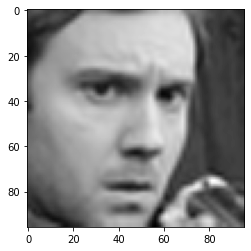

In [60]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')

## VISUALIZE IMAGES AND PLOT LABELS

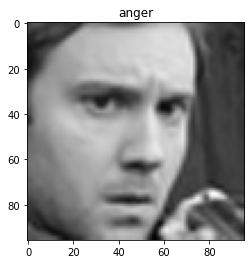

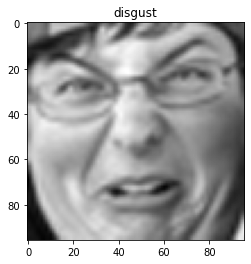

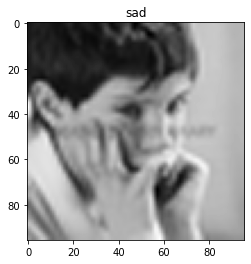

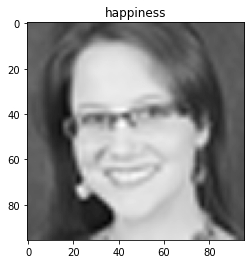

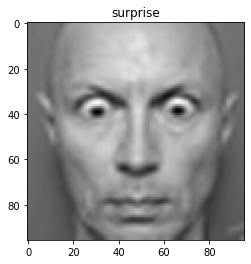

In [61]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [62]:
facialexpression_df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [63]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

<AxesSubplot:ylabel='emotion'>

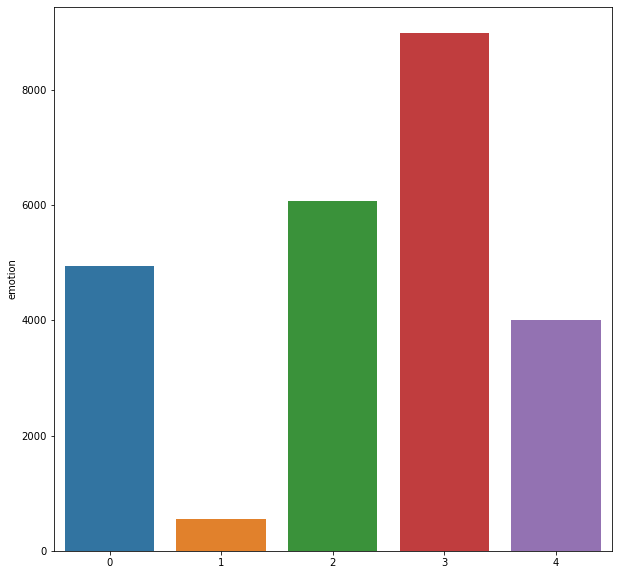

In [64]:
plt.figure(figsize = (10,10))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

## PERFORM DATA PREPARATION AND IMAGE AUGMENTATION 

In [65]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [66]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [67]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [68]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

In [70]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [71]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [72]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [73]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [74]:
X_train

array([[[[0.14338863],
         [0.11023141],
         [0.05485122],
         ...,
         [0.67393154],
         [0.69603485],
         [0.7096258 ]],

        [[0.12775747],
         [0.10191651],
         [0.05857484],
         ...,
         [0.6693553 ],
         [0.6976185 ],
         [0.7149679 ]],

        [[0.10191471],
         [0.08814458],
         [0.06467213],
         ...,
         [0.66238564],
         [0.7007714 ],
         [0.72429687]],

        ...,

        [[0.05275215],
         [0.09293094],
         [0.15883215],
         ...,
         [0.09251787],
         [0.11760176],
         [0.13224582]],

        [[0.0563531 ],
         [0.09596306],
         [0.16088101],
         ...,
         [0.10913774],
         [0.15437065],
         [0.18134753]],

        [[0.05863737],
         [0.09787047],
         [0.16213882],
         ...,
         [0.11901753],
         [0.17663173],
         [0.21118422]]],


       [[[0.67934585],
         [0.6764961 ],
         [0.67

In [75]:
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")

## BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [76]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [77]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [78]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [79]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 2, callbacks=[checkpointer, earlystopping])

Epoch 1/2
345/345 [==============================] - 167s 476ms/step - loss: 1.4971 - accuracy: 0.4023 - val_loss: 1.8613 - val_accuracy: 0.3893

Epoch 00001: val_loss improved from inf to 1.86132, saving model to FacialExpression_weights.hdf5
Epoch 2/2
345/345 [==============================] - 160s 463ms/step - loss: 0.9557 - accuracy: 0.6140 - val_loss: 1.2388 - val_accuracy: 0.4373

Epoch 00002: val_loss improved from 1.86132 to 1.23882, saving model to FacialExpression_weights.hdf5


In [80]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

## ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL 

In [81]:
with open('./Emotion/emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('./Emotion/weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [82]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 3s 59ms/step - loss: 0.3134 - accuracy: 0.8741
Test Accuracy: 0.868999183177948


In [83]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [84]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

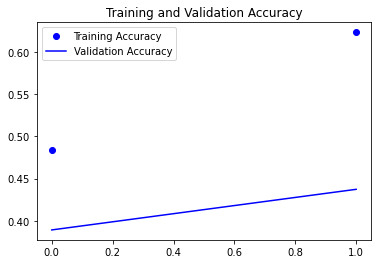

In [85]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

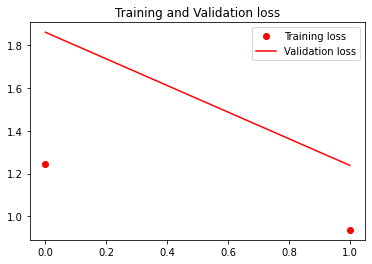

In [86]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [87]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

<AxesSubplot:>

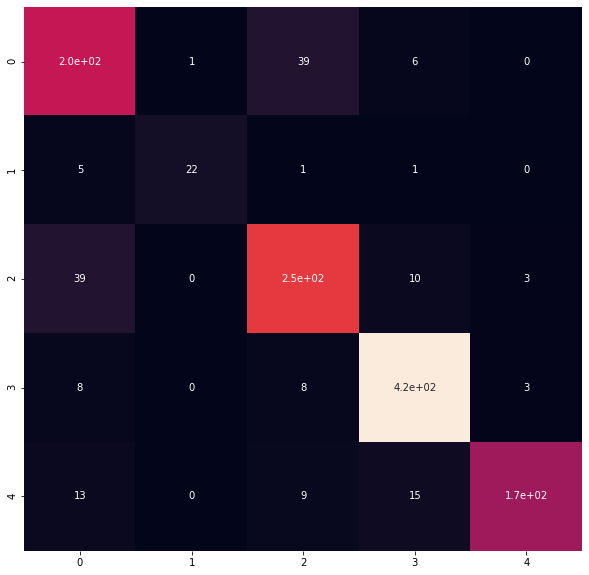

In [88]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

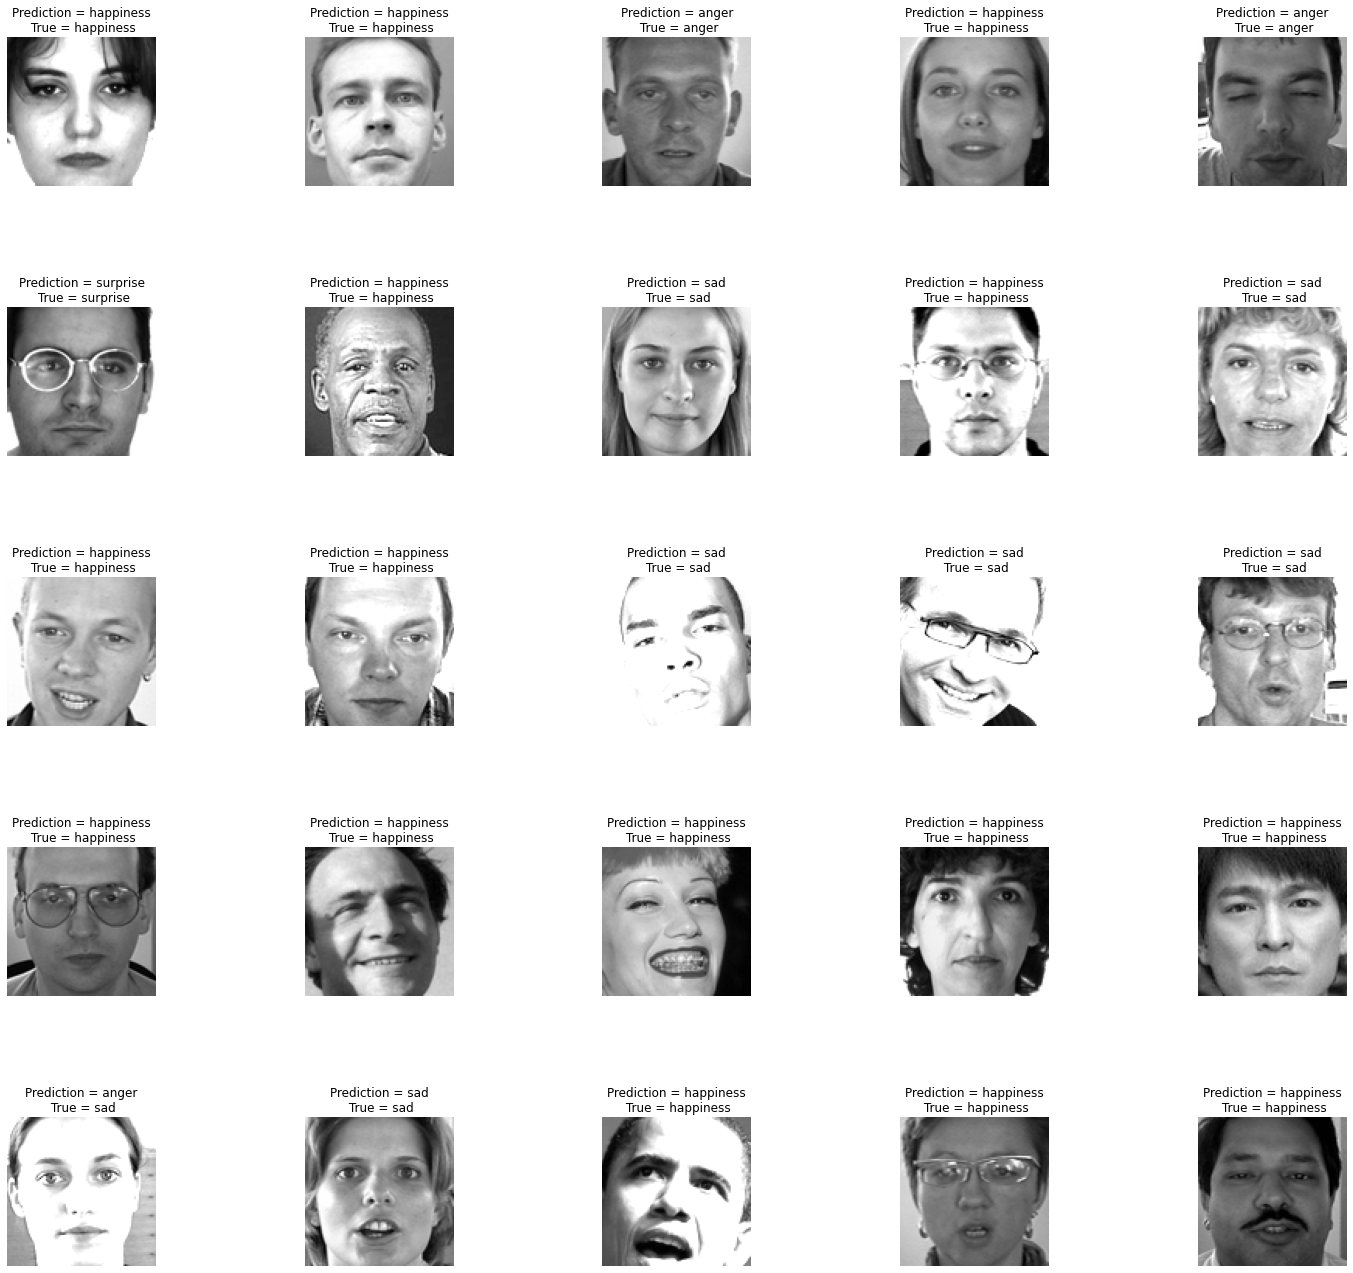

In [89]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1) 

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       251
           1       0.96      0.76      0.85        29
           2       0.81      0.83      0.82       301
           3       0.93      0.96      0.94       443
           4       0.97      0.82      0.89       205

    accuracy                           0.87      1229
   macro avg       0.88      0.84      0.86      1229
weighted avg       0.87      0.87      0.87      1229



## COMBINE BOTH MODELS (1) FACIAL KEY POINTS DETECTION AND (2) FACIAL EXPRESSION MODELS 

In [91]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [92]:
df_predict = predict(X_test)

In [93]:
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          36.076012          27.423933           36.578545   
1          39.865181          27.098822           32.277584   
2          45.750160          26.936993           26.314350   
3          40.975464          26.365086           29.269934   
4          41.596146          26.790070           29.387053   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           28.864700                      0.0                29.192070   
1           28.970583                      0.0                29.273174   
2           28.176596                      0.0                28.611317   
3           27.778170                      0.0                28.380686   
4           28.067827                      0.0                28.487309   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                35.522923                29.991722                 36.322548   
1                40.658722                29.815302                 33.513695   
2                48.778034                29.157146                 29.341431   
3                43.053322                28.568537                 31.016329   
4                43.812740                29.184074                 31.276552   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 28.106747  ...   43.445522            35.065208   
1                 27.659798  ...   43.177864            38.162148   
2                 27.622593  ...   42.491459            43.413132   
3                 27.217215  ...   42.254517            39.637398   
4                 27.429661  ...   42.633095            40.256329   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            56.704582             36.605480             56.213665   
1            56.113255             33.132702             55.789410   
2            55.795975             28.657078             55.701328   
3            55.091000             30.826048             54.757740   
4            55.685204             31.009720             55.335682   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0                     0.0               53.996502                  36.591099   
1                     0.0               53.579079                  36.442467   
2                     0.0               52.650856                  35.981247   
3                     0.0               51.911793                  35.212467   
4                     0.0               52.326111                  35.691853   

   mouth_center_bottom_lip_y  emotion  
0                  62.082973        2  
1                  61.574535        2  
2                  61.163826        2  
3                  60.213989        3  
4                  61.018051        2  

[5 rows x 31 columns]

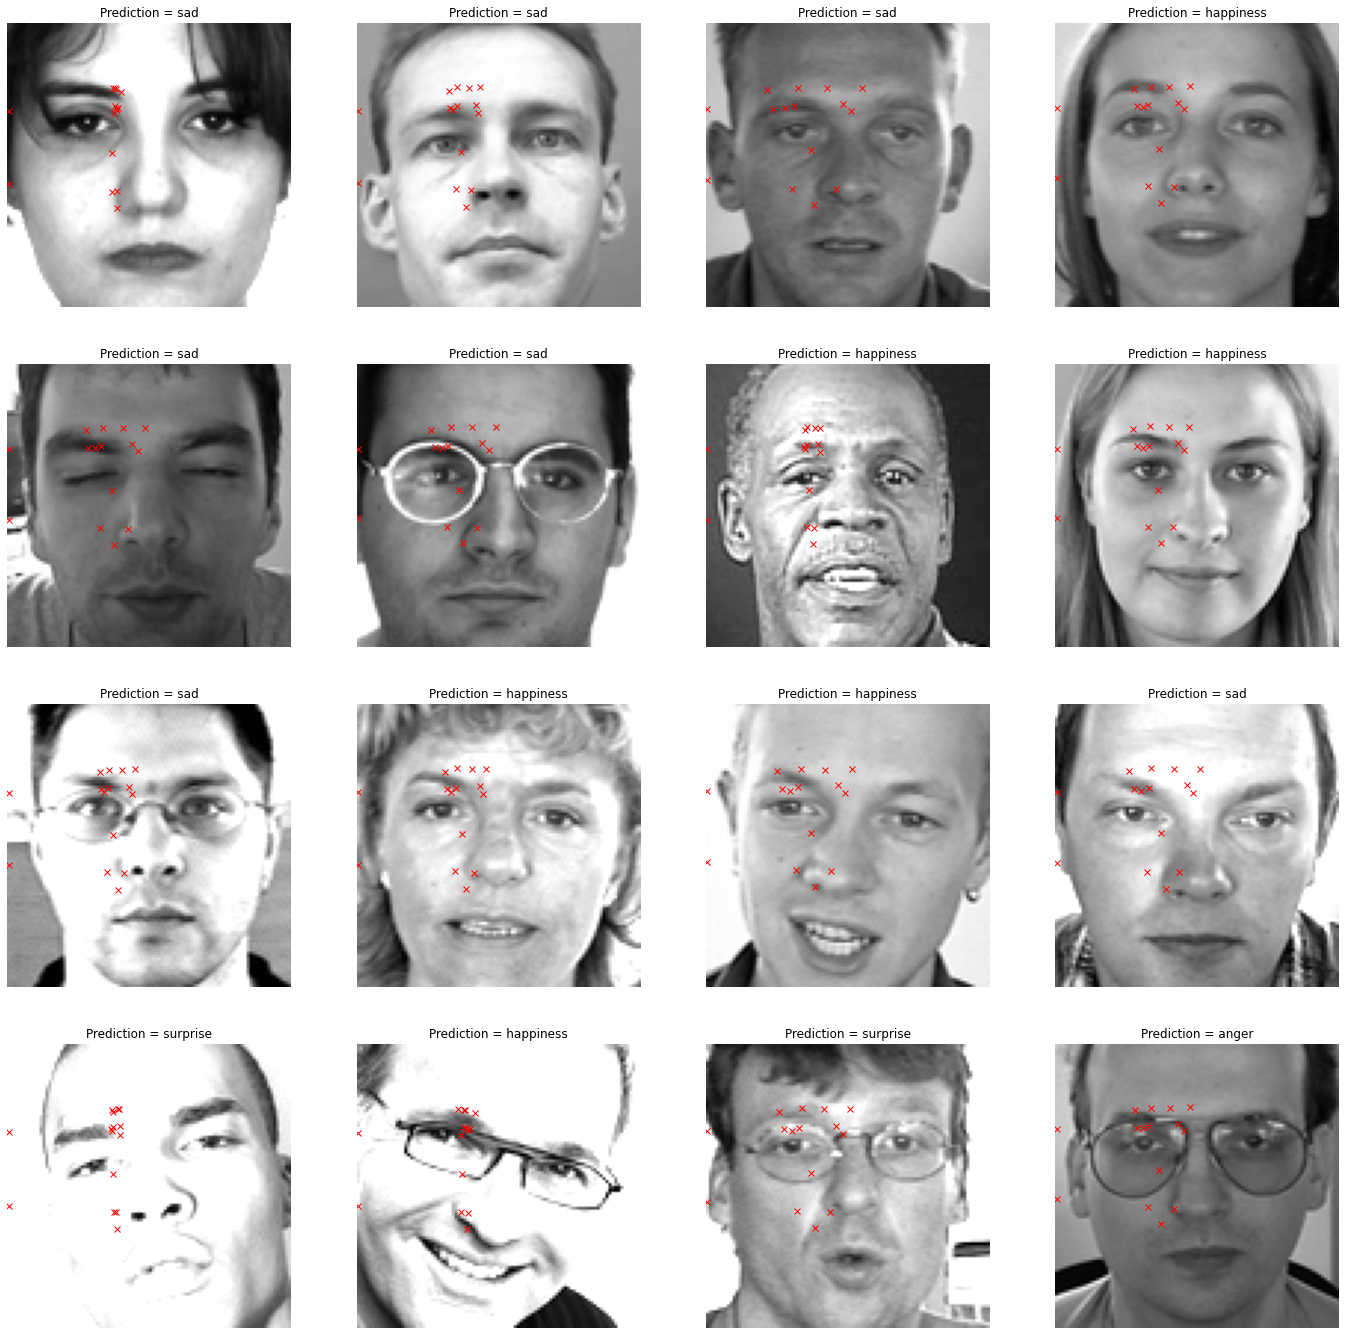

In [95]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in range(16):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')

# DEPLOY BOTH TRAINED MODELS

In [96]:
import json
import tensorflow.keras.backend as K

def deploy(directory, model):
  MODEL_DIR = directory
  version = 1 

  # Let's join the temp model directory with our chosen version number 
  # The expected result will be = '\tmp\version number'
  export_path = os.path.join(MODEL_DIR, str(version))
  print('export_path = {}\n'.format(export_path))

  # Let's save the model using saved_model.save
  # If the directory already exists, we will remove it using '!rm' 
  # rm removes each file specified on the command line. 

  if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

  tf.saved_model.save(model, export_path)

  os.environ["MODEL_DIR"] = MODEL_DIR

In [100]:
# Let's add tensorflow-model-server package to our list of packages 
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

'tee' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Let's install tensorflow model server
!apt-get install tensorflow-model-server

In [ ]:
# Let's run TensorFlow serving

In [99]:
deploy('/model', model_1_facialKeyPoints)

export_path = /model\1



PermissionDeniedError: Failed to create a directory: /; Permission denied [Op:MergeV2Checkpoints]

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4500 \
  --model_name=keypoint_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

In [ ]:
deploy('/model1', model_2_emotion)

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=4000 \
  --model_name=emotion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

## MAKE REQUESTS TO MODEL IN TENSORFLOW SERVING 

In [ ]:
import json

# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

In [ ]:
!pip install -q requests

In [ ]:
import requests

# Function to make predictions from deployed models
def response(data):
  headers = {"content-type": "application/json"}
  json_response = requests.post('http://localhost:4500/v1/models/keypoint_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_predict = json.loads(json_response.text)['predictions']
  json_response = requests.post('http://localhost:4000/v1/models/emotion_model/versions/1:predict', data=data, headers=headers, verify = False)
  df_emotion = np.argmax(json.loads(json_response.text)['predictions'], axis = 1)
  
  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict= pd.DataFrame(df_predict, columns = columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [ ]:
# making prediction
df_predict = response(data)

In [ ]:
df_predict

In [ ]:
# Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(3, 1, figsize = (24, 24))
axes = axes.ravel()

for i in range(3):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')